In [1]:
import torch
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
from inference_attack import *
from model import *

In [2]:
# Configuration
model = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng_seed = 0
dataset_name = "MNIST"                         # "MNIST" or "CIFAR10"
data_path = "./data"

# Part 1 Use pretrained model to create a dataset for gradient classification
pretrained_model_path = "trained_model_MNIST.pth"
criterion_pretrained_model = torch.nn.CrossEntropyLoss()
num_classes = 10
inference_dataset_size = 500
batch_size_pretrained_model = 1

# Part 2 Train gradient classifier on gradient dataset
learning_rate_gradient_classifier = 0.001
criterion_grad_classifier = kl_div
# criterion_grad_classifier = nn.BCELoss()
train_size = 0.7
test_size = 1 - train_size
num_epochs = 3
batch_size_gradient_classifier = 16

# Part 3 Make inference on estimated gradient update
target_model_path = "target_0.pth"
learning_rate_pretrained_model = 0.01

In [3]:
# Make reproducible
random.seed(rng_seed)
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

## Part 1. Use pretrained model to create a dataset for gradient classification

In [4]:
# load dataset (we use test datasets to train the model on samples that have not been used in training of the global model)
if dataset_name == "MNIST":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST(root=data_path, train=False, download=True, transform=transform)
    input_shape = (1, 28, 28)

elif dataset_name == "CIFAR10":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
    dataset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
    input_shape = (3, 32, 32)

else:
    raise ValueError(f"Unsupported dataset: {dataset_name}")

indices = random.sample(range(len(dataset)), inference_dataset_size)
dataset = Subset(dataset, indices=indices)

dataloader = DataLoader(dataset, batch_size=batch_size_pretrained_model, shuffle=False)

In [5]:
# load pretrained model
theta_0 = torch.load(pretrained_model_path)

if model == 1:
    inference_model = Model1(input_shape, num_classes).to(device)
elif model == 2:
    inference_model = Model2(input_shape, num_classes).to(device)
else:
    print('Unknown model:', model)

inference_model.load_state_dict(state_dict=theta_0)

<All keys matched successfully>

In [6]:
# collect gradient features
features = []
labels = []

inference_model.to(device)
inference_model.train() # TODO: eval can make some layers behave differently (Not in our case)

for x, y in dataloader:
    x, y = x.to(device), y.to(device)

    # Forward pass
    output = inference_model(x)
    loss = criterion_pretrained_model(output, y)

    # print("pr:", output, "gt:", y)

    # Compute gradients w.r.t. model parameters
    grad = torch.autograd.grad(loss, inference_model.parameters(), retain_graph=False)
    # grad = torch.autograd.grad(loss, [inference_model.fc1.weight, inference_model.fc1.bias], retain_graph=False)
    grad_vector = torch.cat([g.view(-1) for g in grad])  # Flatten and concatenate

    # Detach and store
    features.append(grad_vector.detach().cpu().float())
    # labels.append(one_hot_encode(y.item(), num_classes))
    labels.append(multi_hot_encode(y, num_classes))
    # print(multi_hot_encode(y, num_classes))
    
    # DEBUG
    if torch.equal(multi_hot_encode(y, num_classes), multi_hot_encode(torch.tensor([7]), num_classes)):
        saved_grad = grad_vector.unsqueeze(0)

features = torch.stack(features)
labels = torch.stack(labels).float()
#labels = torch.stack([y.detach().clone().float32() for y in labels])

dataset = TensorDataset(features, labels)
input_dim = features.shape[1]
output_dim = labels.shape[1]

## Part 2. Train gradient classifier on gradient dataset

In [7]:
# dataset split
tmp_train = int(train_size*inference_dataset_size/batch_size_pretrained_model)
tmp_test = int(inference_dataset_size/batch_size_pretrained_model-tmp_train)
print(tmp_train, tmp_test)

train_dataset, test_dataset = random_split(dataset, [tmp_train, tmp_test])

train_loader = DataLoader(train_dataset, batch_size=batch_size_gradient_classifier, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_gradient_classifier)

350 150


In [8]:
# Model training
grad_classifier_model = GradientClassifier(input_dim=input_dim, output_dim=output_dim)
grad_classifier_model.to(device)

train_grad_classifier(grad_classifier_model, train_loader, test_loader, criterion_grad_classifier, num_epochs=num_epochs, lr=learning_rate_gradient_classifier, device=device)

Epoch 1/3 | Loss: 2.1371 | Accuracy: 0.00%
Test Loss: 1.6636 | Cosine Similarity: 0.9656
Epoch 2/3 | Loss: 1.5057 | Accuracy: 0.00%
Test Loss: 1.4614 | Cosine Similarity: 1.0000
Epoch 3/3 | Loss: 1.4612 | Accuracy: 0.00%
Test Loss: 1.4612 | Cosine Similarity: 1.0000


In [9]:
# Model evaluation
test_preds = evaluate_model(grad_classifier_model, test_loader, criterion_grad_classifier, device)

Test Loss: 1.4612 | Cosine Similarity: 1.0000


## Part 3. Make inference on estimated gradient update

In [10]:
# Estimate the target gradient update as theta_0 - theta_1 / lr
# theta_1 = torch.load(target_model_path)
# est_grad = elementwise_diff_state_dicts(theta_0, theta_1, learning_rate_pretrained_model)
# est_grad_vector = dict_to_tensor(est_grad).unsqueeze(0)
# for key in est_grad.keys():
#     print(est_grad[key].shape)

# est_grad_vector = torch.cat([est_grad[key].view(-1) for key in est_grad.keys()]).unsqueeze(0)

In [25]:
# estimate update gradient and compare with true update
theta_0 = torch.load('trained_model_MNIST.pth')
theta_1 = torch.load('target_0.pth')
est_grad = elementwise_diff_state_dicts(theta_0, theta_1, learning_rate_pretrained_model)

theta_0_D = torch.load('DEBUG_initial_state.pth')
theta_1_D = torch.load('DEBUG_updated_state.pth')
est_grad_D = elementwise_diff_state_dicts(theta_0_D, theta_1_D, learning_rate_pretrained_model)

true_grad = torch.load('DEBUG_true_grads.pth')

print('est_grad and true_grad', state_dicts_average_cosine_similarity(est_grad, true_grad))
print('theta_0 and theta_0_D', state_dicts_average_cosine_similarity(theta_0, theta_0_D))
print('theta_1 and theta_1_D', state_dicts_average_cosine_similarity(theta_1, theta_1_D))
print('est_grad and est_grad_D', state_dicts_average_cosine_similarity(est_grad, est_grad_D))
print('true_grad and est_grad_D', state_dicts_average_cosine_similarity(true_grad, est_grad_D))
print('----------')
culo = elementwise_diff_state_dicts(theta_0, theta_1_D, learning_rate_pretrained_model)
print(state_dicts_average_cosine_similarity(culo, true_grad))

est_grad and true_grad 0.1514223642880097
theta_0 and theta_0_D 1.0000001639127731
theta_1 and theta_1_D 0.9999406039714813
est_grad and est_grad_D 0.15142924978863448
true_grad and est_grad_D 1.000000186264515
----------
1.000000186264515


[0.0, 1.2203284986255641e-14, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


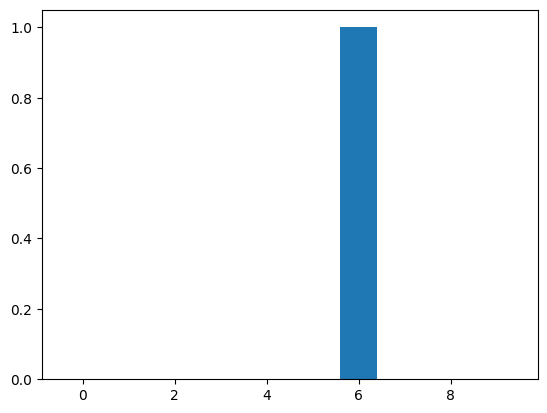

In [25]:
# Inference
inferred = grad_classifier_model(est_grad_vector)
# inferred = grad_classifier_model(saved_grad)
inferred = inferred.tolist()[0]
print(inferred)
plt.bar(range(num_classes), inferred)
plt.show()